In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Embedding,GRU,LSTM,Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


In [2]:
d1=pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)


In [3]:
d2=pd.read_json("s2.json", lines=True)


In [4]:
data=pd.concat([d1,d2])


In [5]:
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
# data.tail()
data.drop_duplicates(subset ="article_link")


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
28497,https://www.theonion.com/tyson-holds-contest-t...,tyson holds contest to let fans submit new ide...,1
28509,https://politics.theonion.com/increasingly-coc...,increasingly cocky bernie sanders announces he...,1
28520,https://www.theonion.com/cash-strapped-zuckerb...,cash-strapped zuckerberg forced to sell 11 mil...,1
28544,https://local.theonion.com/grocery-store-bar-a...,grocery store bar actually has great little ha...,1


In [7]:
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [8]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [9]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    head_lines = list()
    lines = df["headline"].values.tolist()

    for line in lines:
        line = clean_text(line)
        tokens = word_tokenize(line)
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

head_lines = CleanTokenize(data)
head_lines[0:10]


[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  'black',
  'code',
  'minority',
  'shoppers'],
 ['roseanne',
  'revival',
  'catches',
  'thorny',
  'political',
  'mood',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  'sons',
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen',
  'come',
  'alternative',
  'debtreduction',
  'ideas'],
 ['jk', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'magical', 'way'],
 ['advancing', 'worlds', 'women'],
 ['fascinating', 'case', 'eating', 'labgrown', 'meat'],
 ['ceo', 'send', 'kids', 'school', 'work', 'company'],
 ['top', 'snake', 'handler', 'leaves', 'sinking', 'huckabee', 'campaign'],
 ['fridays', 'morning', 'email', 'inside', 'trumps', 'presser', 'ages']]

(-0.5, 999.5, 499.5, -0.5)

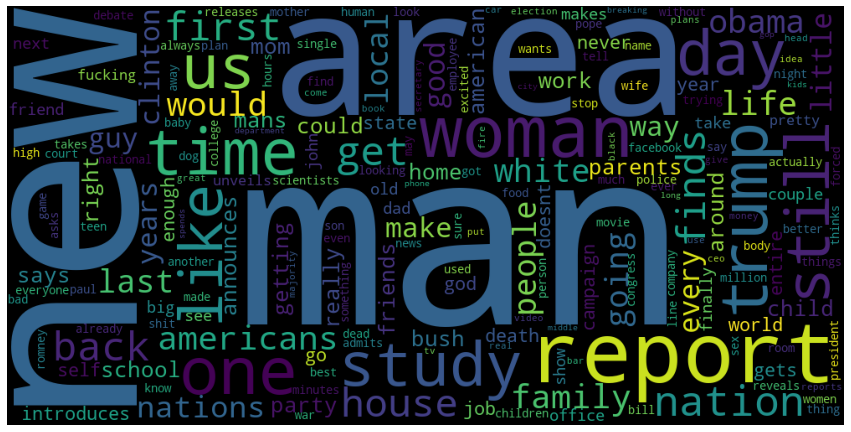

In [10]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator 
pos_data = data.loc[data['is_sarcastic'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

In [11]:
validation_split = 0.2
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['is_sarcastic'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  28657
vocab size - 28658


In [12]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (44263, 25)
Shape of y_train: (44263,)
Shape of X_test_pad: (11065, 25)
Shape of y_test: (11065,)


In [13]:


embeddings_index = {}
embedding_dim = 100
GLOVE_DIR = "glove.twitter.27B.100d"
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.100d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 1193514 word vectors.


In [14]:
#Build embedding layer

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)


24755


In [15]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)


## Build the LSTM

In [16]:
model = Sequential()
model.add(embedding_layer)
# model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(LSTM(64, dropout=0.4, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())


Summary of the built model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 100)           2865800   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,908,105
Trainable params: 42,305
Non-trainable params: 2,865,800
_________________________________________________________________
None


In [17]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)
  # yaha se run                  

Epoch 1/25
1384/1384 - 28s - loss: 0.5386 - acc: 0.7275 - val_loss: 0.4952 - val_acc: 0.7761 - 28s/epoch - 20ms/step
Epoch 2/25
1384/1384 - 25s - loss: 0.4622 - acc: 0.7804 - val_loss: 0.4055 - val_acc: 0.8107 - 25s/epoch - 18ms/step
Epoch 3/25
1384/1384 - 24s - loss: 0.4320 - acc: 0.7990 - val_loss: 0.3851 - val_acc: 0.8257 - 24s/epoch - 18ms/step
Epoch 4/25
1384/1384 - 25s - loss: 0.4101 - acc: 0.8125 - val_loss: 0.3619 - val_acc: 0.8387 - 25s/epoch - 18ms/step
Epoch 5/25
1384/1384 - 25s - loss: 0.3946 - acc: 0.8204 - val_loss: 0.3587 - val_acc: 0.8416 - 25s/epoch - 18ms/step
Epoch 6/25
1384/1384 - 25s - loss: 0.3806 - acc: 0.8284 - val_loss: 0.3458 - val_acc: 0.8488 - 25s/epoch - 18ms/step
Epoch 7/25
1384/1384 - 26s - loss: 0.3700 - acc: 0.8336 - val_loss: 0.3499 - val_acc: 0.8437 - 26s/epoch - 18ms/step
Epoch 8/25
1384/1384 - 27s - loss: 0.3608 - acc: 0.8400 - val_loss: 0.3281 - val_acc: 0.8550 - 27s/epoch - 20ms/step
Epoch 9/25
1384/1384 - 27s - loss: 0.3543 - acc: 0.8433 - val_lo

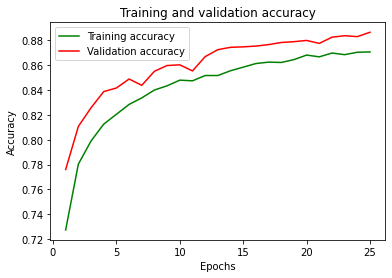

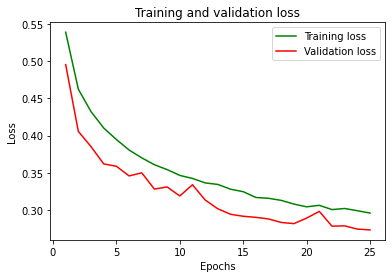

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [19]:
def predict_sarcasm(s ):
    x_final = pd.DataFrame({"headline":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's a sarcasm!" 
    else: return "It's not a sarcasm."

In [20]:
predict_sarcasm("I was depressed. He asked me to be happy. I am not depressed anymore.")

"It's a sarcasm!"

In [21]:
predict_sarcasm("You just broke my car window. Great job.")

"It's a sarcasm!"

In [22]:
predict_sarcasm("You just saved my dog's life. Thanks a million.")

"It's not a sarcasm."

In [23]:
predict_sarcasm("I want a million dollars!")

"It's not a sarcasm."

In [24]:
predict_sarcasm("I just won a million dollars!")

"It's a sarcasm!"

In [25]:
predict_sarcasm("His name is Bob. He is a nice person.")

"It's a sarcasm!"

In [26]:
predict_sarcasm("Sarcasm is very easy to detect.")

"It's not a sarcasm."

## SVM

In [27]:
from sklearn.svm import SVC
svm_model = SVC()

In [28]:
svm_model.fit(X_train_pad, y_train)

SVC()

In [29]:
svm_model.score(X_test_pad, y_test)

0.6060551287844554

In [30]:
from sklearn.metrics import confusion_matrix

y_predsvm = svm_model.predict(X_test_pad)
cmsvm = confusion_matrix(y_test, y_predsvm)
cmsvm

array([[5090,  928],
       [3431, 1616]], dtype=int64)

In [54]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import seaborn as sn
# plt.figure(figsize =(7,5))
# sn.heatmap(cmsvm, annot =True)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predsvm))

              precision    recall  f1-score   support

           0       0.60      0.85      0.70      6018
           1       0.64      0.32      0.43      5047

    accuracy                           0.61     11065
   macro avg       0.62      0.58      0.56     11065
weighted avg       0.61      0.61      0.58     11065



## Naive Bayes

In [33]:
len(X_train_pad)

44263

In [34]:
len(X_test_pad)

11065

In [35]:
len(y_train)

44263

In [36]:
len(y_test)

11065

In [37]:
from sklearn.naive_bayes import GaussianNB
naive_model = GaussianNB()

In [38]:
naive_model.fit(X_train_pad, y_train)

GaussianNB()

In [39]:
naive_model.score(X_test_pad, y_test)

0.5575237234523271

In [40]:
from sklearn.metrics import confusion_matrix

y_predn = naive_model.predict(X_test_pad)
cmn = confusion_matrix(y_test, y_predn)

In [41]:
cmn


array([[5982,   36],
       [4860,  187]], dtype=int64)

In [53]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import seaborn as sn
# plt.figure(figsize =(7,5))
# sn.heatmap(cmn, annot =True)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predn))

              precision    recall  f1-score   support

           0       0.55      0.99      0.71      6018
           1       0.84      0.04      0.07      5047

    accuracy                           0.56     11065
   macro avg       0.70      0.52      0.39     11065
weighted avg       0.68      0.56      0.42     11065



## KNN

In [44]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model.fit(X_train_pad, y_train)

KNeighborsClassifier(n_neighbors=10)

In [45]:
knn_model.score(X_test_pad,y_test)

0.6164482602801626

In [46]:
from sklearn.metrics import confusion_matrix

y_pred = knn_model.predict(X_test_pad)
cm = confusion_matrix(y_test, y_pred)

In [47]:
cm

array([[4646, 1372],
       [2872, 2175]], dtype=int64)

In [52]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import seaborn as sn
# plt.figure(figsize =(7,5))
# sn.heatmap(cm, annot =True)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')


In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.77      0.69      6018
           1       0.61      0.43      0.51      5047

    accuracy                           0.62     11065
   macro avg       0.62      0.60      0.60     11065
weighted avg       0.62      0.62      0.60     11065



## Bar Chart

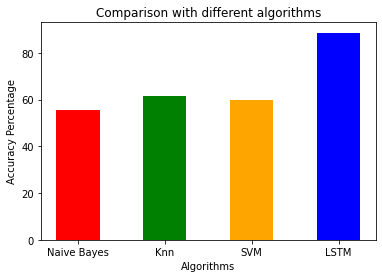

In [50]:
import matplotlib.pyplot as plt
x=["Naive Bayes", "Knn", "SVM","LSTM"]
y=[55.33, 61.57, 59.88, 88.61]
c=["red","green","orange","blue"]
plt.bar(x,y,width=0.5, color=c)
plt.xlabel('Algorithms')
plt.ylabel('Accuracy Percentage')
plt.title("Comparison with different algorithms")
plt.show()


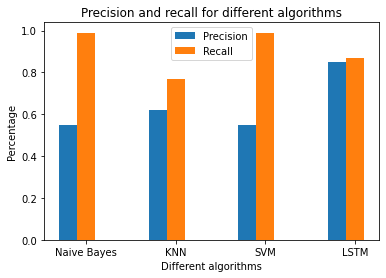

In [51]:
import matplotlib.pyplot as plt
import numpy as np
w=0.2
x=["Naive Bayes", "KNN", "SVM", "LSTM"]
precision=[0.55,0.62,0.55,0.85]
recall=[0.99,0.77,0.99,0.87]
# f1score=[0.71,0.68,0.71]
# accuracy=[0.55,0.61,0.59,0.88]

bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+w for i in bar2]

plt.bar(bar1,precision,w,label="Precision")
plt.bar(bar2,recall,w,label="Recall")
# plt.bar(bar3,accuracy,w,label="Accuracy")

plt.xlabel("Different algorithms")
plt.ylabel("Percentage")
plt.title("Precision and recall for different algorithms")

plt.xticks(bar1+w, x)
plt.legend()
plt.show()
